In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
def Bfield(r):
    M = 1.2 #in T (also known as remanance)
    V = 10*25*3e-9 #in m3, volume of magnet stack
    m = num*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
    a = 1*inch
    ax = 1.5*inch
    posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [3]:
num=6

y = np.linspace(-1*inch, 1*inch, 15)
z = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

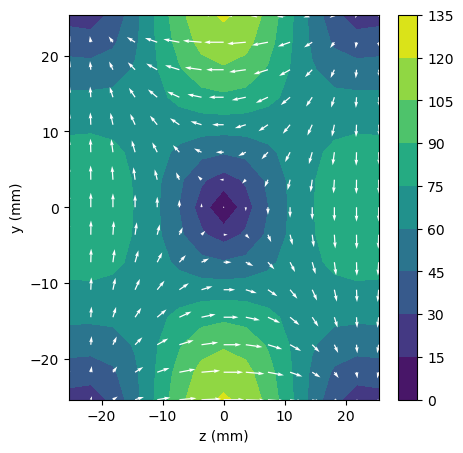

In [4]:
plt.figure(figsize=(5,5))
plot = plt.contourf(z*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],z[0],z[-1]], origin='lower', levels=10)
plt.quiver(z*1e3, y*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [5]:
def line(x, a, b):
    return a*(x)+b

gradient: -63.18031029120689 G/cm


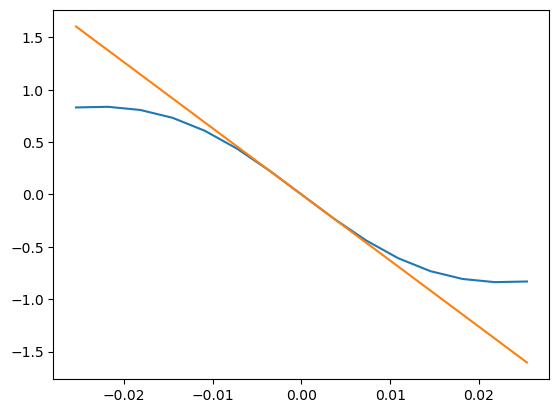

In [6]:
popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(y, By[8,:]*1e4/1e2)
plt.plot(y, line(y, *popt))
print('gradient:', popt[0], 'G/cm')

In [7]:
y = np.linspace(-0.3*inch, 0.3*inch, 15)
x = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in y] for xx in x])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(x))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


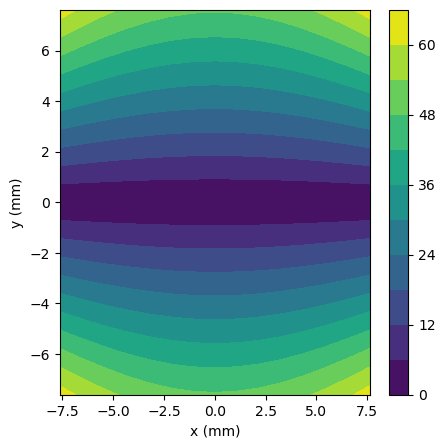

In [8]:
plt.figure(figsize=(5,5))
plot=plt.contourf(x*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],x[0],x[-1]], origin='lower', levels=10)
plt.quiver(x*1e3, y*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [9]:
num_array = np.linspace(1, 6, 10, endpoint=True)
grad_array = []

for num in num_array:
    y = np.linspace(-1*inch, 1*inch, 15)
    z = np.linspace(-1*inch, 1*inch, 15)

    rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

    B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
    Bx = B[:,:][0]
    By = B[:,:][1]
    Bz = B[:,:][2]
    Bmag = np.sqrt(By**2+Bz**2+Bx**2)
    
    popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
    grad_array.append(popt[0])

In [10]:
conv_grad = np.mean(np.divide(grad_array, num_array))

# Monte Carlo

https://arxiv.org/abs/physics/0103085v1

In [119]:
_lambda = 399e-9
k = 2*np.pi/_lambda
Isat = 60e-3*1e4 #W/m2
Gamma = 30e6
w1 = 20e-3
w2 = 5e-3
P = 180e-3
I0 = 2*P/np.pi/w1/w2
m171 = 171*u
Delta = -2*Gamma
dt = 1e-5

#slower:
wslower = 3e-3
Pslower = 150e-3
I0slower = 2*Pslower/np.pi/wslower**2
Deltaslower = -40*Gamma

gravity = g*np.array([0,-1,0])

In [120]:
I0slower/Isat

17.683882565766147

In [121]:
L = 1
S = 0
J = 1
I = 1/2
F = 3/2

gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ


In [122]:
def Zeeman_shift(dmF, r):

    B = np.sqrt(np.sum(np.square(Bfield(r))))
    
    return mB*gF*B*dmF/hbar

In [123]:
def epsilon(k, q):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    
    if q==1:
        return -1/np.sqrt(2)*(z+1j*ihat)
    elif q==0:
        return jhat
    elif q==-1:
        return 1/np.sqrt(2)*(z-1j*ihat)

def rotation_matrix(k, r, pol):
    knorm = k/np.linalg.norm(k)
    B = Bfield(r)
    Bnorm = B/np.linalg.norm(B)
    cos = np.dot(knorm, Bnorm)
    sin = np.sqrt(1-cos**2)
    
    Mq = 1/2* np.array( [[1+cos, -np.sqrt(2)*sin, 1-cos], 
                           [np.sqrt(2)*sin, 2*cos, -np.sqrt(2)*sin], 
                           [1-cos, np.sqrt(2)*sin, 1+cos] ]  )
    
    return np.matmul(Mq,pol)

In [124]:
def forceSlower(r, v):
    '''force from a slower laser beam via transition j (delta m == -j)'''
    
    f = 0
    stot = []
    Rtot = 0
    
    for idx,j in enumerate([1, 0, -1]):

        Wj = np.abs(rotation_matrix(kslower, r, polslower)[idx])**2

        dist = np.sqrt(np.sum( np.abs(np.cross(r, kslower/k))**2))
        Ii = I0*np.exp( -2*dist**2/wslower**2)
        sij = Ii* Wj/Isat        
            
        stot.append(sij)
    
        
    for idx,j in enumerate([1, 0, -1]):
        dmF = -j
        deltaij = Deltaslower - np.dot(kslower, v) - Zeeman_shift(dmF, r)
        sij = stot[idx]
        Rij = Gamma/2 * sij/(1+4*(deltaij/Gamma)**2)
        Rtot = Rtot+Rij

    fslower = hbar*kslower*Rtot
    f = f + fslower
        
    #add random scattering force
    kscatt = np.array([np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)])
    kscatt = kscatt/np.linalg.norm(kscatt)
    fr = hbar*k*kscatt*np.sqrt(Rtot/dt)
        
    f = f# + fr
        
    return f #+ gravity*m171

In [125]:
def force2Dmot(r, v):
    '''force from a laser beam i via transition j (delta m == -j)'''
    
    f = 0
    stot = []
    Rtot = []
    
    #saturation for mot beams
    for i in range(4):
        
        si = []
    
        for idx,j in enumerate([1, 0, -1]):

            Wj = np.abs(rotation_matrix(ki[i], r, poli[i])[idx])**2
            
            dist_yz = np.sqrt(np.sum( np.abs(np.cross(r[1:], ki[i][1:]/k))**2))
            Ii = I0*np.exp( -2*r[0]**2/w1**2 -2*dist_yz**2/w2**2 )
            sij = Ii* Wj/Isat        
            
            si.append(sij)
            
        stot.append(si)
    
    #scattering rate for mot beams
    for i in range(4):
        
        si = stot[i]
        Ri = 0
        
        for idx,j in enumerate([1, 0, -1]):
            dmF = -j
            deltaij = Delta - np.dot(ki[i], v) - Zeeman_shift(dmF, r)
            sij = si[idx]
            Rij = Gamma/2 * sij/(1+np.sum(stot)+4*(deltaij/Gamma)**2)
            Ri = Ri+Rij
        
        Rtot.append(Ri)
  
        fi = hbar*ki[i]*Ri
        f = f + fi
        
    #add random scattering force
    for i in range(4):
        kscatt = np.array([0,np.random.uniform(0, 1),np.random.uniform(0, 1)])
        kscatt = kscatt/np.linalg.norm(kscatt)
        fr = hbar*k*kscatt*np.sqrt(Rtot[i]/dt)
        
        f = f# + fr
        
    return f + gravity*m171

In [126]:
def RK4(xn, vn, f):
    
    h = dt

    k1x = vn
    k1v = f(xn, vn)/m171
    
    k2x = vn + k1v*h/2
    k2v = f(xn + k1x*h/2, vn + k1v*h/2)/m171
    
    k3x = vn + k2v*h/2
    k3v = f(xn + k2x*h/2, vn + k2v*h/2)/m171
    
    k4x = vn + k3v*h
    k4v = f(xn + k3x*h, vn + k3v*h)/m171
    
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)
    xn1 = xn + (k1x + 2*k2x + 2*k3x + k4x)*(h/6)

    return xn1, vn1, f(xn, vn)

In [127]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

ki = k*np.array( [ -y+z, -y-z, y+z, y-z]) #, -y+z, -y-z wavevectors of the mot beams
poli = np.array( [ epsilon(ki[0], 1), epsilon(ki[1], 1), epsilon(ki[2], 1), epsilon(ki[3], 1)]) #

kslower = -y*k
polslower = x

In [128]:
def test_truncnorm(loc, scale, bounds):
    while True:
        s = np.random.normal(loc, scale)
        if bounds[0] <= s <= bounds[1]:
            break
    return s

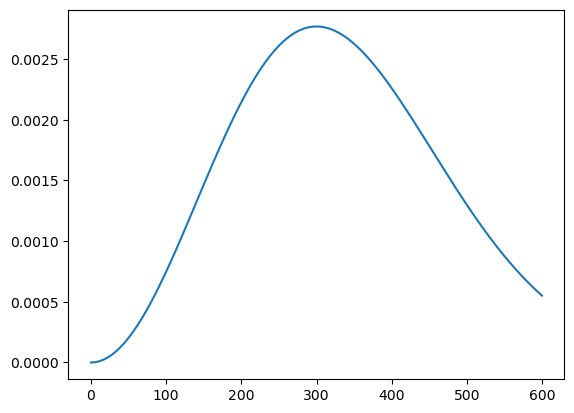

In [129]:
def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

dv = 0.1
v = np.arange(0, 600, dv)

Tl = 925
vlp = np.sqrt(2*kB*Tl/m171)
vlexp = 2/np.sqrt(np.pi)*vlp
vlrms = np.sqrt(3/2)*vlp

y = MB_speed(v,m171,Tl)

plt.plot(v, y)

In [130]:
Tl = 925
def MBsample(Tl):
    i = 0
    dv = 0.1
    v = np.arange(0, 600, dv)
    
    while i<1:
        vi = np.random.choice(v)
        y = MB_speed(vi,m171,Tl)
        eps = np.random.random()
        if eps<y*dv:
            i = i+1
        else:
            i=i
    return vi

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.58it/s]


(array([ 3.,  6., 11., 12., 15., 13., 16., 14.,  5.,  5.]),
 array([ 54.  , 108.26, 162.52, 216.78, 271.04, 325.3 , 379.56, 433.82,
        488.08, 542.34, 596.6 ]),
 <BarContainer object of 10 artists>)

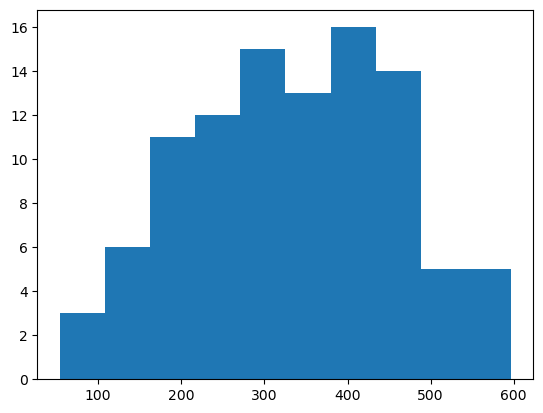

In [178]:
N = 100
tot = []
for i in tqdm.tqdm(range(N)):
    tot.append(MBsample(Tl))
plt.hist(tot)

In [173]:
Deltaslower = -75*Gamma
num = 2.5
r0 = np.array([0.,-2.48*25.4e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)

vx0 =  0
vy0 =  105#, MBsample(Tl)
vz0 =  0
v0 = np.array([vx0, vy0, vz0])

pos_array = []
vel_array = []
f_array = []
count_array = []
B_array = []

r = r0
v = v0
a = gravity

count = 0
tot_count = 4000
while count<tot_count:
    r, v, f = RK4(r, v, forceSlower)
    pos_array.append(r)
    vel_array.append(v)
    count_array.append(count)
    f_array.append(f)
    B = np.sqrt(np.sum(np.square(Bfield(r))))
    B_array.append(B)
    count = count+1
    if abs(r[1])<w2:
        count = tot_count
    
pos_array = np.real(np.array(pos_array) )
vel_array = np.real(np.array(vel_array) )
count_array = np.array(count_array)
f_array = np.array(f_array)
B_array = np.array(B_array)

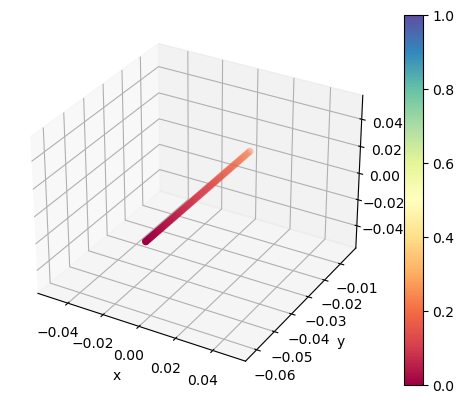

In [174]:
ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
zplot = pos_array[:,2]
xplot = pos_array[:,0]
yplot = pos_array[:,1]

cmap = plt.get_cmap("Spectral")
sm =  ScalarMappable(cmap=cmap)
sm.set_array([])
ax.scatter(xplot, yplot, zplot, c=cmap(count_array))

plt.xlabel('x')
plt.ylabel('y')

cbar = plt.colorbar(sm, ax=ax)
plt.show()


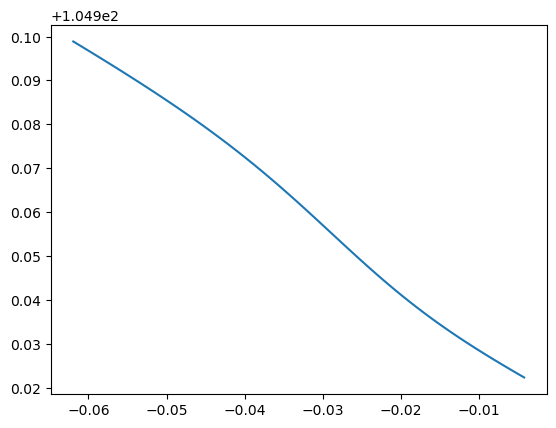

In [175]:
plt.plot(pos_array[:, 1], vel_array[:, 1])

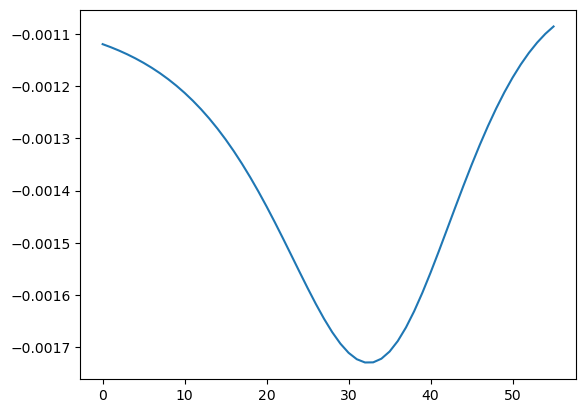

In [176]:
plt.plot(f_array[:,1]/m171*dt)

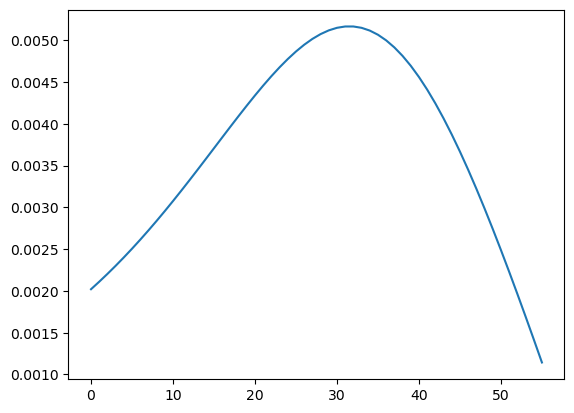

In [170]:
plt.plot(B_array)

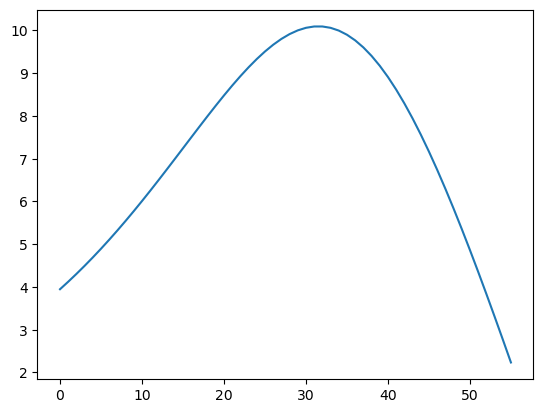

In [171]:
plt.plot(mB*gF*B_array/hbar/Gamma)

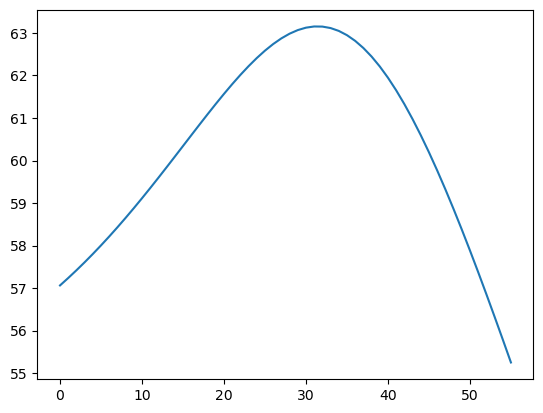

In [172]:
plt.plot(Delta/Gamma+mB*gF*B_array/hbar/Gamma+k*vel_array[:,1]/Gamma)

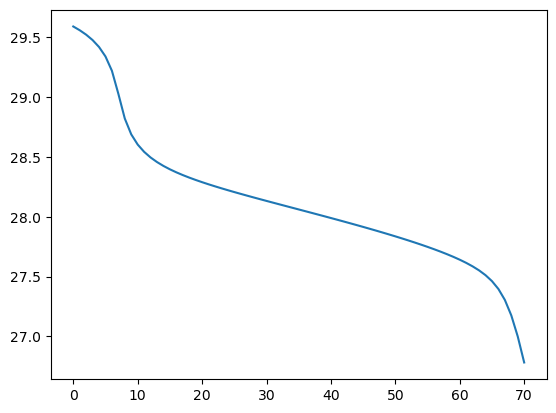

In [59]:
plt.plot(Delta/Gamma+k*vel_array[:,1]/Gamma)

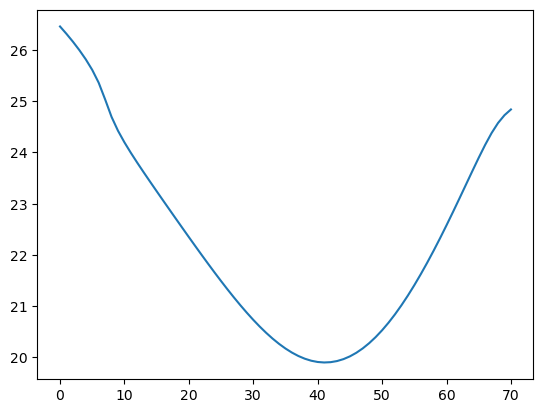

In [60]:
plt.plot(Delta/Gamma-mB*gF*B_array/hbar/Gamma+k*vel_array[:,1]/Gamma)

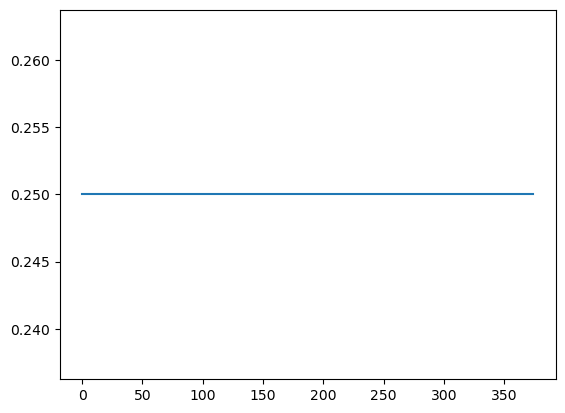

In [447]:
plt.plot([np.abs(rotation_matrix(kslower, r, polslower)[0])**2 for r in pos_array])

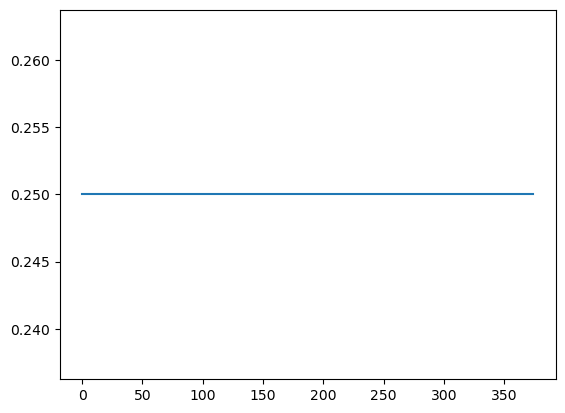

In [428]:
plt.plot([np.abs(rotation_matrix(kslower, r, polslower)[-1])**2 for r in pos_array])

In [460]:
Deltaslower_ls = np.linspace(-60*Gamma, -20*Gamma, 100)
num = 4
r0 = np.array([0.,-260e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
v_fin = []

for Deltaslower in Deltaslower_ls:
    vx0 =  0
    vy0 =  85#, MBsample(Tl)
    vz0 =  0
    v0 = np.array([vx0, vy0, vz0])

    r = r0
    v = v0
    a = gravity

    count = 0
    tot_count = 4000
    while count<tot_count:
        r, v, f = RK4(r, v, forceSlower)
        #pos_array.append(r)
        #vel_array.append(v)
        #count_array.append(count)
        #f_array.append(f)
        #B = np.sqrt(np.sum(np.square(Bfield(r))))
        #B_array.append(B)
        count = count+1
        if abs(r[1])<w2:
            count = tot_count
            
    v_fin.append(v)
    
#pos_array = np.real(np.array(pos_array) )
#vel_array = np.real(np.array(vel_array) )
#count_array = np.array(count_array)
#f_array = np.array(f_array)
#B_array = np.array(B_array)

(40.0, 90.0)

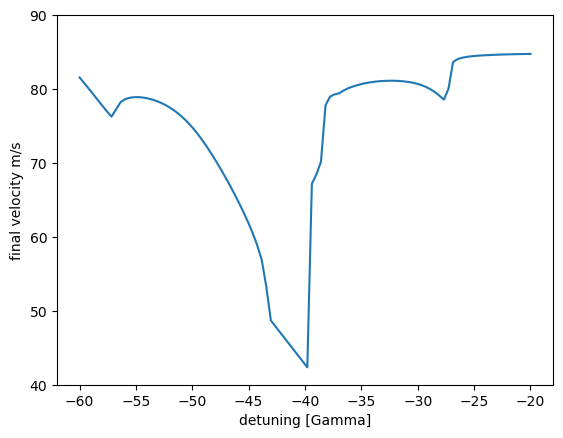

In [462]:
plt.plot(Deltaslower_ls/Gamma, np.array(v_fin)[:,1])
plt.xlabel('detuning [Gamma]')
plt.ylabel('final velocity m/s')
plt.ylim(40, 90)

In [464]:
Deltaslower_ls = np.linspace(-60*Gamma, -20*Gamma, 100)
num = 4
r0 = np.array([0.,-260e-3, 0.])

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
trapped_fin = []

for idx in tqdm.tqdm(range(len(Deltaslower_ls))):
    Deltaslower = Deltaslower_ls[idx]
    trapped = 0

    for N in range(100):
        vy0 =  MBsample(Tl)
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0
        a = gravity
        count = 0
        tot_count = 4000
        while count<tot_count:
            r, v, f = RK4(r, v, forceSlower)
            count = count+1
            if abs(r[1])<w2:
                count = tot_count
        if 0<v[1]<50:        
            trapped = trapped+1
            
    trapped_fin.append(trapped)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [50:46<00:00, 30.47s/it]


(40.0, 90.0)

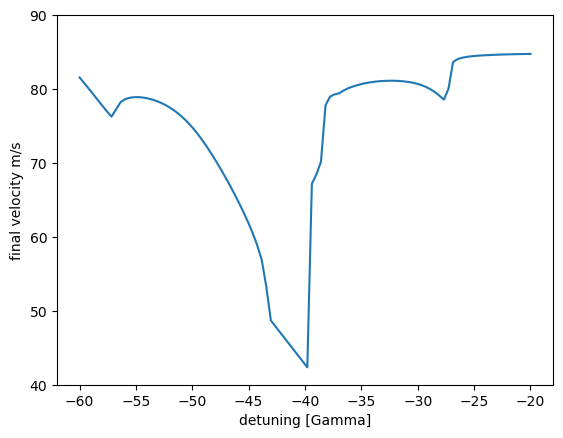

In [465]:
plt.plot(Deltaslower_ls/Gamma, np.array(v_fin)[:,1])
plt.xlabel('detuning [Gamma]')
plt.ylabel('final velocity m/s')
plt.ylim(40, 90)